In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from tensorflow.keras import Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional, Dropout, LeakyReLU, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_data = h5py.File(r'/content/drive/MyDrive/Data/Multiple Factors Generated Data/ZNF_train_3000_100.h5', 'r')
test_data = h5py.File(r'/content/drive/MyDrive/Data/Multiple Factors Generated Data/ZNF_test_3000_010.h5', 'r')  

train_data_binlabels, train_data_features = np.array(train_data['binlabels']), np.array(train_data['data'])
test_data_binlabels, test_data_features = np.array(test_data['binlabels']), np.array(test_data['data'])

train_data_features = np.array([i.T for i in train_data_features])
test_data_features = np.array([i.T for i in test_data_features])

train_data.close()
test_data.close()

In [4]:
def plot_loss_and_AUC(model_history):
  fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

  ax[0].plot(model_history.history["loss"])
  ax[0].plot(model_history.history["val_loss"])
  ax[0].title.set_text('model train loss vs validation loss')
  ax[0].set(xlabel="loss", ylabel="epoch")
  ax[0].legend(['train', 'validation'], loc='upper right')

  ax[1].plot(model_history.history["AUC"])
  ax[1].plot(model_history.history["val_AUC"])
  ax[1].title.set_text('model train accuracy vs validation accuracy')
  ax[1].set(xlabel="accuracy", ylabel="epoch")
  ax[1].legend(['train', 'validation'], loc='lower right')

  plt.show()

In [5]:
clear_session()

input_layer = Input(shape = (1000, 4))

hidden_layer = Conv1D(filters = 50, kernel_size = 10, padding = "same", activation = LeakyReLU(alpha=0))(input_layer)
hidden_layer = MaxPooling1D(pool_size = 4, strides = 4)(hidden_layer)
hidden_layer = Conv1D(filters = 100, kernel_size = 4, padding = "same", activation = LeakyReLU(alpha=0))(hidden_layer)
hidden_layer = MaxPooling1D(pool_size = 4, strides = 4)(hidden_layer)
hidden_layer = Bidirectional(LSTM(units = 100))(hidden_layer)
hidden_layer = Dense(units = 100, activation = LeakyReLU())(hidden_layer)

output = Dense(29, activation = "sigmoid")(hidden_layer)

multilabel_model = Model(inputs = input_layer, outputs=output)
 
multilabel_model.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(beta_1 = 0.95),
    metrics = [AUC(name = "AUC", multi_label = True)]
)

multilabel_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 4)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 50)          2050      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 100)          20100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 100)          0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800

In [6]:
callback = [EarlyStopping(patience = 3)]

multilabel_model_history = multilabel_model.fit(train_data_features, train_data_binlabels, epochs = 50, batch_size = 1000, validation_split = 5e-2, shuffle = True, callbacks = callback)  

Epoch 1/50
950/950 [==============================] - 225s 223ms/step - loss: 0.3265 - AUC: 0.4829 - val_loss: 0.3238 - val_AUC: 0.4838
Epoch 2/50
950/950 [==============================] - 212s 223ms/step - loss: 0.3239 - AUC: 0.4843 - val_loss: 0.3236 - val_AUC: 0.4892
Epoch 3/50
950/950 [==============================] - 213s 224ms/step - loss: 0.3132 - AUC: 0.5436 - val_loss: 0.2928 - val_AUC: 0.5744
Epoch 4/50
950/950 [==============================] - 213s 224ms/step - loss: 0.2774 - AUC: 0.6044 - val_loss: 0.2624 - val_AUC: 0.6259
Epoch 5/50
950/950 [==============================] - 212s 223ms/step - loss: 0.2478 - AUC: 0.6478 - val_loss: 0.2357 - val_AUC: 0.6599
Epoch 6/50
950/950 [==============================] - 212s 223ms/step - loss: 0.2239 - AUC: 0.6768 - val_loss: 0.2111 - val_AUC: 0.6946
Epoch 7/50
950/950 [==============================] - 212s 223ms/step - loss: 0.2026 - AUC: 0.7104 - val_loss: 0.1907 - val_AUC: 0.7203
Epoch 8/50
950/950 [============================

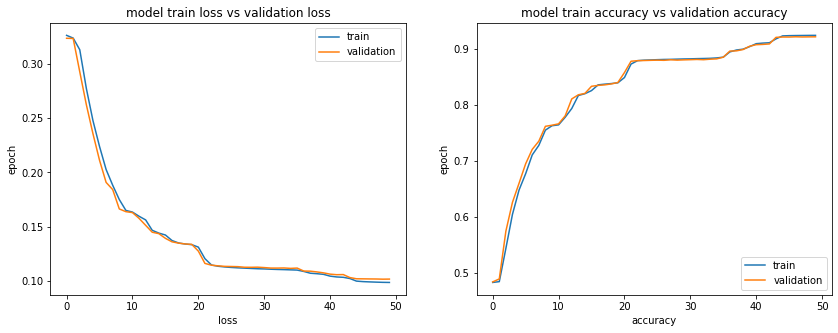

3125/3125 [==============================] - 58s 18ms/step - loss: 0.1018 - AUC: 0.9211


[0.10182563215494156, 0.9210681319236755]

In [7]:
plot_loss_and_AUC(multilabel_model_history)

multilabel_model.evaluate(test_data_features, test_data_binlabels)

In [8]:
multilabel_model.save('/content/drive/MyDrive/Data/convrnn_multilabel_classification_29_factors.h5')